#Assignment 02: Usage of Word2Vecs Models on the Consumer Complaints Dataset

Name: Daniel Podolecki
\
Date: 16.12.2022

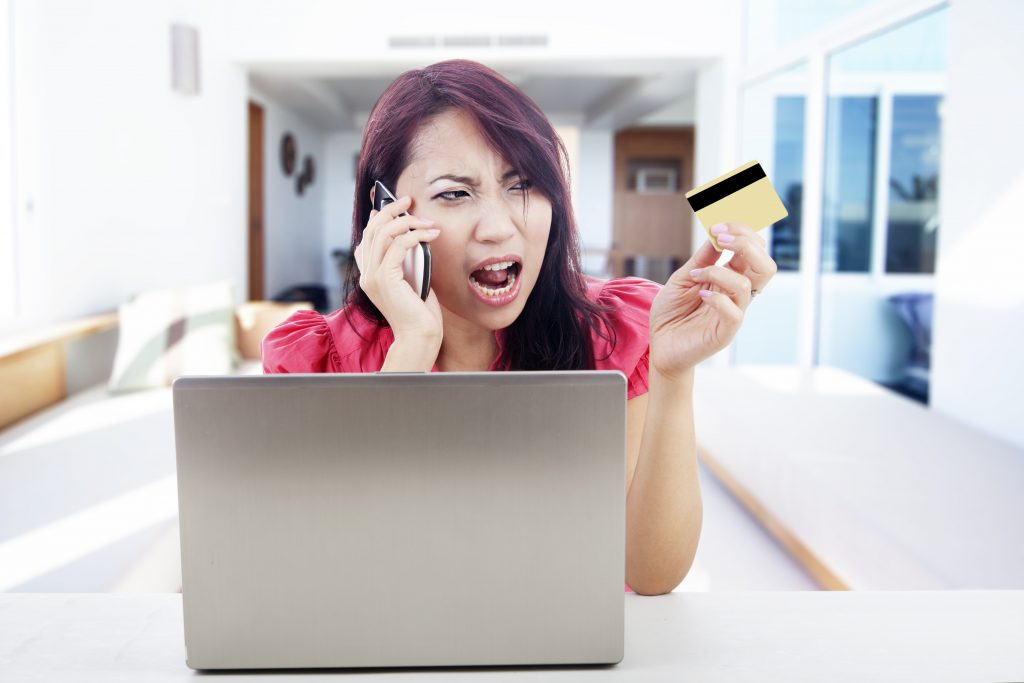

Picture: A Womain complaining about her credit card ([Source](https://www.affirmx.com/wp-content/uploads/2017/03/Dollarphotoclub_45280771-1024x683.jpg))

## Setup


In [ ]:
from google.colab import drive
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from pprint import pprint
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Binarizer
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from spacy.lang.en import English
import scipy.sparse as sp
from collections import Counter
from gensim.models import Word2Vec
import gensim.downloader as api
import nltk
from gensim.parsing.preprocessing import remove_stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from nltk.corpus import wordnet as wn
from nltk.corpus import wordnet_ic

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## The Dataset

My Data for this assignment is originated with the Consumer Financial Protection Bureau (CFPB) - a US federal agency that serves as a mediator between financial institutions and consumers in the event of a dispute. Via a web form, the data can be entered by the consumer with a text and tagged to a product class.

The Data can be downloaded as CSV from the Consumer Financial Protection Bureau (CFPB) and can be reproduced via this direct link (a download will automatically start): 
https://www.consumerfinance.gov/data-research/consumer-complaints/search/api/v1/?date_received_max=2021-12-31&date_received_min=2019-12-31&field=all&format=csv&has_narrative=true&no_aggs=true&size=378244&sort=created_date_desc


In [ ]:
# Define data folder:
data_folder = Path("/content/drive/MyDrive/CLT/Colab Notebooks/Exercise_02/data/")

# Path of product category data
data = data_folder/"complaints.csv"

In [ ]:
df_complaints_complete = pd.read_csv(data)
df_complaints_complete.head(5)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,08/20/21,Debt collection,Credit card debt,Attempts to collect debt not owed,Debt was result of identity theft,Account Name : CAPITAL ONE BANK USA N Account ...,None,CAPITAL ONE FINANCIAL CORPORATION,AZ,85296,None,Consent provided,Web,09/09/21,Closed with explanation,Yes,NaN,4648945
1,08/27/21,Student loan,Federal student loan servicing,Dealing with your lender or servicer,Received bad information about your loan,"In XXXX, my employer and employment were certi...",None,AES/PHEAA,IN,46214,None,Consent provided,Web,08/27/21,Closed with explanation,Yes,NaN,4667415
2,10/11/21,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,This dispute is for an account balance via XXX...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",TX,77378,None,Consent provided,Web,10/11/21,Closed with explanation,Yes,NaN,4801008
3,11/19/21,Debt collection,Other debt,Attempts to collect debt not owed,Debt was result of identity theft,RE : Attentively review my formal writ compose...,None,ENCORE CAPITAL GROUP INC.,PA,19020,None,Consent provided,Web,11/19/21,Closed with non-monetary relief,Yes,NaN,4929608
4,02/22/21,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account information incorrect,WFDS XXXX Balance : {$0.00} XXXX XXXX XXXX Bal...,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,CA,94602,None,Consent provided,Web,02/22/21,Closed with explanation,Yes,NaN,4157279


In [ ]:
# We only need the "Consumer complaint narrative" for this exercise. To have still a data frame I will keep the Complaint ID.
df_complaints = df_complaints_complete.loc[:,["Complaint ID","Consumer complaint narrative"]]
df_complaints.head(5)

,Complaint ID,Consumer complaint narrative
0,4648945,Account Name : CAPITAL ONE BANK USA N Account ...
1,4667415,"In XXXX, my employer and employment were certi..."
2,4801008,This dispute is for an account balance via XXX...
3,4929608,RE : Attentively review my formal writ compose...
4,4157279,WFDS XXXX Balance : {$0.00} XXXX XXXX XXXX Bal...


## Text Pre-Processing

In [ ]:
# Download packages
nltk.download('stopwords')
#nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Tokenization
nlp = English(disable=['tagger', 'parser', 'ner'])

def tokenize(text):
  return [t.text.lower() for t in nlp(text)]  

In [ ]:
# Apply Tokenization               
df_complaints['Tokens'] = df_complaints['Consumer complaint narrative'].apply(tokenize)
#df_complaints['Tokens'] = df_complaints['Consumer complaint narrative'].apply(word_tokenize) #another approach
df_complaints.head()

,Complaint ID,Consumer complaint narrative,Tokens
0,4648945,Account Name : CAPITAL ONE BANK USA N Account ...,"[account, name, :, capital, one, bank, usa, n,..."
1,4667415,"In XXXX, my employer and employment were certi...","[in, xxxx, ,, my, employer, and, employment, w..."
2,4801008,This dispute is for an account balance via XXX...,"[this, dispute, is, for, an, account, balance,..."
3,4929608,RE : Attentively review my formal writ compose...,"[re, :, attentively, review, my, formal, writ,..."
4,4157279,WFDS XXXX Balance : {$0.00} XXXX XXXX XXXX Bal...,"[wfds, xxxx, balance, :, {, $, 0.00, }, xxxx, ..."


In [ ]:
# Definition of stop_words language
stop_words = nltk.corpus.stopwords.words('english')

# Stop Words Removal
def remove_stopwords(text):
    t = [token for token in text if token not in stop_words]
    #text = ' '.join(t) -> as text instead 
    return t

In [ ]:
# Apply Stop Words Removal
df_complaints['Tokens_No_Stopwords'] = df_complaints['Tokens'].apply(remove_stopwords)
df_complaints.head()

,Complaint ID,Consumer complaint narrative,Tokens,Tokens_No_Stopwords
0,4648945,Account Name : CAPITAL ONE BANK USA N Account ...,"[account, name, :, capital, one, bank, usa, n,...","[account, name, :, capital, one, bank, usa, n,..."
1,4667415,"In XXXX, my employer and employment were certi...","[in, xxxx, ,, my, employer, and, employment, w...","[xxxx, ,, employer, employment, certified, cou..."
2,4801008,This dispute is for an account balance via XXX...,"[this, dispute, is, for, an, account, balance,...","[dispute, account, balance, via, xxxxxxxx, xxx..."
3,4929608,RE : Attentively review my formal writ compose...,"[re, :, attentively, review, my, formal, writ,...","[:, attentively, review, formal, writ, compose..."
4,4157279,WFDS XXXX Balance : {$0.00} XXXX XXXX XXXX Bal...,"[wfds, xxxx, balance, :, {, $, 0.00, }, xxxx, ...","[wfds, xxxx, balance, :, {, $, 0.00, }, xxxx, ..."


## Discrete Vectorization Methods (Recap)

Feature extraction in NLP is often called vectorization.
A word embedding is an embedding in which words or other symbols are each assigned to a vector.

### Bag of Words (BoW)

BoW is counting a frequency for each word in a text. The bag-of-words representations describe one document.

In [ ]:
# Create vectorizer
text = df_complaints["Consumer complaint narrative"]
cv = CountVectorizer(min_df=0., max_df=1.)

# Create vector by passing the text corpus into the vectorizer to get back counts
cv_matrix = cv.fit_transform(text)
cv_matrix

<204066x63831 sparse matrix of type '<class 'numpy.int64'>'
	with 17406439 stored elements in Compressed Sparse Row format>

In [ ]:
# Number of different entries
print("Different entries:", len(cv.vocabulary_))

#Showing 20 vocabulary entries
print("Example entries:")
for count, entry in enumerate(cv.vocabulary_):
  if count < 20:
    print(count, entry)
  else: break

In [ ]:
print(cv_matrix)

  (0, 4387)	2
  (0, 37747)	1
  (0, 11805)	1
  (0, 39752)	1
  (0, 9072)	1
  (0, 59273)	1
  (0, 39017)	1
  (0, 62177)	2
  (0, 17232)	1
  (0, 39917)	1
  (0, 62164)	2
  (0, 1348)	1
  (0, 8969)	1
  (0, 45425)	1
  (0, 29307)	1
  (0, 55401)	1
  (0, 42509)	1
  (0, 46991)	1
  (0, 32290)	1
  (0, 25856)	1
  (0, 37557)	1
  (0, 16431)	1
  (0, 47336)	1
  (1, 9072)	2
  (1, 39017)	1
  :	:
  (204065, 44621)	1
  (204065, 58030)	1
  (204065, 4768)	1
  (204065, 617)	3
  (204065, 841)	1
  (204065, 1410)	2
  (204065, 59306)	3
  (204065, 48673)	2
  (204065, 60196)	1
  (204065, 11879)	1
  (204065, 7176)	1
  (204065, 58120)	1
  (204065, 50307)	2
  (204065, 18226)	1
  (204065, 8471)	1
  (204065, 12774)	3
  (204065, 5201)	1
  (204065, 32697)	3
  (204065, 7316)	1
  (204065, 23378)	1
  (204065, 24474)	1
  (204065, 17379)	1
  (204065, 731)	2
  (204065, 43710)	1
  (204065, 56045)	1


Interpretation: e.g. The document zero (with id of 0) has the word '4387' 2 times.

In [ ]:
# Corpus
vocab = cv.get_feature_names_out()
print(vocab) 

# Final Matrix  --> Collab will crash, therefore commented out
# cv_matrix = cv_matrix.toarray()
#pd.DataFrame(cv_matrix, columns=vocab)

['00' '000' '0000' ... 'zutafi' 'zwicker' 'zwickerpc']


Lets try it out with less data:

In [ ]:
# Create vectorizer
sample = df_complaints["Consumer complaint narrative"][0:1000]
cv = CountVectorizer(min_df=0., max_df=1.)

# Create vector by passing the text corpus into the vectorizer to get back counts
cv_matrix = cv.fit_transform(sample)
cv_matrix

<1000x6458 sparse matrix of type '<class 'numpy.int64'>'
	with 94825 stored elements in Compressed Sparse Row format>

In [ ]:
# Corpus
vocab = cv.get_feature_names_out()
print(vocab) 

# matrix to array
cv_matrix = cv_matrix.toarray()
print(cv_matrix)

# Final Matrix
final_matrix = pd.DataFrame(cv_matrix, columns=vocab)
final_matrix

# rows are the documents, coloumns the features

['00' '000' '07' ... 'zions' 'zip' 'zro']
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


,00,000,07,10,100,1000,10000,100000,1001,1005,...,youve,yr,yrs,zell,zelle,zero,zion,zions,zip,zro
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


One example: In the document 1 the word "zero" appears one time. The word 00 appears 2 times in the document 4.

In [ ]:
#Lets inspect this text where "zero" should be part of the content:
df_complaints.iloc[1,1]

'In XXXX, my employer and employment were certified and counted toward PSLF. I reapplied XX/XX/XXXX to update the past year of payments and I received a notice from FedLoan that my employment was not certified because my employer is " for-profit. \'\' I used the PSLF tool on XXXX so that I could submit the information about my employer, but the tool did NOT work, even after trying multiple browsers and different days. I tried contacting the Federal Student loan office by phone several times and the people that I was able to get in contact with told me that there was nothing they could do about the online tool not working and there was no alternate way to submit that information. I eventually contacted the Ombudsman group, who connected me to a representative at FedLoan that handled my inquiry. On XX/XX/XXXX, I received a notice that my employment was certified along with an update of my qualifying my payments. Now on XX/XX/XXXX, I received a notice in my paperless inbox from FedLoan wi

Text indentified: "I now have ZERO qualifying payments,"

#### Ngrams Representation

In [ ]:
# n-gram range = 1,2 to get unigrams as well as bigrams
bi_cv = CountVectorizer(ngram_range=(1, 2))
bi_cv_matrix = bi_cv.fit_transform(sample)

bi_cv_matrix = bi_cv_matrix.toarray()
vocab = bi_cv.get_feature_names()
pd.DataFrame(bi_cv_matrix, columns=vocab)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,00,00 110,00 1st,00 2000,00 220,00 370,00 43,00 50,00 5months,00 90,...,zero sense,zion,zion bank,zions,zions bank,zip,zip code,zro,zro for,zro from
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


With that the number of columns was increased from 6458 to 65074.
One example of a bigram is the zero sense. One example an unigram is zion.

### One Hot Encoding

In [ ]:
# Full Text --> Collab will crash 
#text = df_complaints["Consumer complaint narrative"]
#cv = CountVectorizer()

#cv_matrix = cv.fit_transform(text)                
#vocab = cv.get_feature_names_out()

#onehot = Binarizer()
#oh_matrix = onehot.fit_transform(cv_matrix.toarray())
#print(oh_matrix)
#pd.DataFrame(oh_matrix, columns=vocab)

In [ ]:
# Sample
text = df_complaints["Consumer complaint narrative"][0:1000]
cv = CountVectorizer()

cv_matrix = cv.fit_transform(text)                
vocab = cv.get_feature_names_out()

onehot = Binarizer()
oh_matrix = onehot.fit_transform(cv_matrix.toarray())
print(oh_matrix)
pd.DataFrame(oh_matrix, columns=vocab)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


,00,000,07,10,100,1000,10000,100000,1001,1005,...,youve,yr,yrs,zell,zelle,zero,zion,zions,zip,zro
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Interpretation: The word zero appears in the document number 1. But in contrast to BOW we dont know how many times, because it can only take values from 0 to 1.

### TF-IDF

TF-IDF(t, d) = TF(t, d) * IDF(t)

TF(t,d) = count of t in d / number of words in d --> BOW  \
DF(t) = number of documents (N) where t occurs -- Document Frequency of Words \
IDF(t) = number of documents (N)/DF -- Inverse Document Frequency of Words


In [ ]:
tv = TfidfVectorizer(min_df=0.,
                     max_df=1.,
                     norm='l2',
                     use_idf=True,
                     smooth_idf=True,
                     ngram_range= (1,1))

tv_matrix = tv.fit_transform(sample)

tv_matrix = tv_matrix.toarray()
vocab = tv.get_feature_names_out()
pd.DataFrame(np.round(tv_matrix, 2), columns=vocab)

,00,000,07,10,100,1000,10000,100000,1001,1005,...,youve,yr,yrs,zell,zelle,zero,zion,zions,zip,zro
0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
1,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.0
2,0.14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
3,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
4,0.14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
996,0.23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
997,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
998,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0


## Distributed Vectorization Methods

#### Word2Vec Models

The main parameters of the model:
* `sentences` - a list of the tokenized texts we will use
* `size` - the dimensionality of the word embedding (100 means each word is mapped to a 100 element vector). 
* `window` - the distance in number of words considered "in context" for a given target word. Larger windows (>5) result in embeddings that are more reflective of word meaning. Smaller windows result in embeddings that are more reflective of word syntax (how it is used in a sentence). For example, "good" and "bad" have opposite meaning but similar syntax, i.e. you can replace one with the other in most sentences without violating any grammatical rules.
*` min_count` - This is the minimum count of words to consider when training the model; words with an occurrence less than this number will be ignored.
* `sg` – training algorithm: 1 for skip-gram; 0 for CBOW. 

CBOW tries to predict a word on the basis of its neighbors, while Skip Gram tries to predict the neighbors of a word. CBOW tends to find the probability of a word occurring in a context. So, it generalizes over all the different contexts in which a word can be used.

Input: Text --> Output: Set of Word Vectors (Text with Context/ Similar Meaning)

I train now my first Word 2 Vec Model:

In [ ]:
# Word 2 Vec Model - Complete Data 
## The Computation will take some time!!

feature_size = 300  # Word vector dimensionality
window_context = 5  # Context window size
min_word_count = 5  # Minimum word count
sg = 0

w2vmodel_complete = Word2Vec(sentences=df_complaints['Tokens_No_Stopwords'], size=feature_size, window=window_context, min_count=min_word_count, sg = sg)

In [ ]:
# Lets print some of the trained words:
words_complete=list(w2vmodel_complete.wv.vocab)
print(words_complete)

['account', 'name', ':', 'capital', 'one', 'bank', 'usa', 'n', 'number', 'xxxx', 'date', 'opened', 'xx', '/', 'xx/2015', 'balance', 'reason', 'identity', 'theft', 'please', 'remove', 'credit', 'report', '.', ',', 'employer', 'employment', 'certified', 'counted', 'toward', 'pslf', 'reapplied', 'update', 'past', 'year', 'payments', 'received', 'notice', 'fedloan', '"', '-', 'profit', "''", 'used', 'tool', 'could', 'submit', 'information', 'work', 'even', 'trying', 'multiple', 'browsers', 'different', 'days', 'tried', 'contacting', 'federal', 'student', 'loan', 'office', 'phone', 'several', 'times', 'people', 'able', 'get', 'contact', 'told', 'nothing', 'online', 'working', 'alternate', 'way', 'eventually', 'contacted', 'ombudsman', 'group', 'connected', 'representative', 'handled', 'inquiry', 'along', 'qualifying', 'paperless', 'inbox', 'subject', 'payment', 'summary', 'states', 'zero', 'however', 'specific', 'explanation', 'randomly', 'happened', 'called', 'informed', 'additional', 'let

In [ ]:
# Vector representation of the word "bank"
w2vmodel_complete["bank"]

<ipython-input-24-d1f473511a5e>:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  w2vmodel_complete["bank"]


array([ 0.03857828,  0.34071946, -0.29435492, -2.18604   ,  0.27750635,
       -0.7257487 ,  2.3668244 ,  0.67997473,  1.9606731 , -0.7740591 ,
        0.9915134 , -0.50752777, -0.6360845 , -0.33697125, -0.39752188,
       -0.51647   , -0.38667306, -0.04165078,  0.7793474 ,  0.80579126,
        0.7798166 , -1.2804189 , -0.44190982,  1.7811522 ,  1.004486  ,
        0.72635025, -0.6426933 ,  1.7654668 , -3.240297  , -1.9489944 ,
       -0.6571044 , -1.8246586 , -1.5799695 ,  1.1171207 ,  0.77912545,
        0.63668025, -1.1637623 , -0.16594635,  0.18747573, -0.42428696,
       -1.6206627 ,  0.8453225 , -0.61384743,  0.83026916,  0.4187044 ,
       -0.6240259 ,  0.72248197, -0.21354067,  2.555573  ,  0.25177592,
        0.3988888 , -1.0139246 ,  0.8991526 ,  2.4043689 ,  0.83090943,
       -0.8098647 ,  0.26619512,  0.67642176,  0.6831871 , -0.30709004,
       -0.31816846, -0.11859045, -0.3184062 ,  0.20551544,  0.37616482,
       -0.682862  , -0.28307787, -0.11333142,  0.03052058, -0.82

In [ ]:
# Store the words in a dataframe (will be later needed for PCA)
X=w2vmodel_complete[w2vmodel_complete.wv.vocab]
df=pd.DataFrame(words_complete)
print(df.shape)
df.head()

(24014, 1)


<ipython-input-25-379b9b9c0797>:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  X=w2vmodel_complete[w2vmodel_complete.wv.vocab]


,0
0,account
1,name
2,:
3,capital
4,one


Since the computation of the complete data is too slow, I will limit the data. I will train now foour different Word 2 Vec Models with different params on a reduced dataset.

In [ ]:
#  Word 2 Vec - Model 1

feature_size = 300   
window_context = 10  # Increased to 10
min_word_count = 5  
sg = 0

w2v_model1 = Word2Vec(sentences=df_complaints['Tokens_No_Stopwords'][0:5000], size=feature_size, window=window_context, min_count=min_word_count, sg = sg)

In [ ]:
# Word 2 Vec - Model 2

feature_size = 300 
window_context = 3  # Decreased to 3
min_word_count = 5  
sg = 0

w2v_model2 = Word2Vec(sentences=df_complaints['Tokens_No_Stopwords'][0:5000], size=feature_size, window=window_context, min_count=min_word_count, sg = sg)

In [ ]:
# Word 2 Vec - Model 3

feature_size = 500  # Increased to 500
window_context = 5  
min_word_count = 5  
sg = 0

w2v_model3 = Word2Vec(sentences=df_complaints['Tokens_No_Stopwords'][0:5000], size=feature_size, window=window_context, min_count=min_word_count, sg = sg)

In [ ]:
# Word 2 Vec - Model 4

feature_size = 300  
window_context = 5  
min_word_count = 5  
sg = 1 # Changed to Skip Gram

w2v_model4 = Word2Vec(sentences=df_complaints['Tokens_No_Stopwords'][0:5000], size=feature_size, window=window_context, min_count=min_word_count, sg = sg)

### Pretrained word embeddings

These are the Pretrained word embeddings:

In [ ]:
# Glove from Stanford NLP Group
glove_vectors = api.load("glove-wiki-gigaword-100")               

[=================================================-] 99.4% 127.3/128.1MB downloaded


In [ ]:
# Fasttext from Facebook
ft_vectors = api.load('fasttext-wiki-news-subwords-300')   

[==================================================] 100.0% 958.5/958.4MB downloaded


### Comparison of the embeddings: Find similar words

#### Most frequent words

First I will query the most frequent words, that will be the basis for the most_similar check.

In [ ]:
# Most Frequent Words
from itertools import chain
from collections import Counter

tokens_list = df_complaints["Tokens_No_Stopwords"]
most_common = Counter(chain(*tokens_list)).most_common(50)
most_common

[('xxxx', 1740568),
 ('.', 1643619),
 (',', 1028225),
 ('/', 535566),
 ('xx', 492933),
 ('credit', 398870),
 ('account', 297713),
 (')', 267558),
 ('(', 259259),
 ('report', 203883),
 ('information', 183446),
 ('\n\n', 170215),
 ('$', 155407),
 ('{', 148362),
 ('}', 148320),
 (':', 136092),
 ('reporting', 133793),
 ('-', 108910),
 ('debt', 102274),
 ('consumer', 102116),
 ('payment', 98283),
 ('accounts', 97931),
 ('would', 92114),
 (' ', 90960),
 ('received', 84597),
 ('bank', 83203),
 ('\n', 83106),
 ('company', 80359),
 ('sent', 79877),
 ('days', 77667),
 ('card', 74383),
 ('also', 72040),
 ('time', 72036),
 ('loan', 71697),
 ('never', 68831),
 ('letter', 67456),
 ('told', 66207),
 ("n't", 59609),
 ('xx/2021', 58863),
 ('identity', 58424),
 ('called', 58020),
 ('number', 57571),
 ('dispute', 57439),
 ('due', 56742),
 ('back', 56664),
 ('please', 56274),
 ('!', 55962),
 ('date', 55325),
 ('payments', 53694),
 ('amount', 52824)]

In [ ]:
most_common_words = ["xxxx",".", "credit", "account", "information", "consumer", "payment", "would", "bank", "company", "days", "loan", "told", "dispute"]

In [ ]:
# Most frequent words - Model Complete Data
print("Model Complete")
counter = 0
for word in most_common_words:
  counter +=1
  print(counter, word, w2vmodel_complete.wv.most_similar(word, topn=5))
  print(30*"~")

Model Complete
1 xxxx [(' ', 0.8601366281509399), ('xxxxxxxx', 0.8232834339141846), ('wi', 0.7092016935348511), ('xxxx/', 0.7062435150146484), ('md', 0.6951181292533875)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2 . [(',', 0.5294934511184692), ('..', 0.4378475248813629), ('!', 0.4232921302318573), ('?', 0.34187477827072144), ('....', 0.3405689597129822)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
3 credit [('trans', 0.39697694778442383), ('experian', 0.3776417076587677), ('consumer', 0.3710023760795593), ('xxxxcredit', 0.3601117432117462), ('negative', 0.3533116579055786)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
4 account [('accounts', 0.649964451789856), ('acct', 0.5623220205307007), ('accout', 0.5191864967346191), ('acount', 0.5017485618591309), ('account-', 0.4242629408836365)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
5 information [('info', 0.6986606121063232), ('informations', 0.5068429112434387), ('data', 0.49938637018203735), ('infomation', 0.4580353796482086), ('formation', 0.4416638910770416)]
~~~~~~~~~~~~~~~~~~~~~~~

The results are quite accurate for many  words and sometimes even interesting.
following are some interpretations:

- The dot **"."** is rightly detected to any punctuation marks e.g. ','
- From all of these 15 words the words '**credit'**  and **consumer** hast the lowest similarity with any other word. 
- For **'would'** the most similiar word is 'd' which is a bit strange, because its only one letter. More accurate are 'could' or 'wanted'.
- The word **'days'** is detected as most similar with words which are time driven like minutes or seconds.
- The word **'loan'** shows that the common words are streamline, mortgage (a specific form of loan) or  heloc  aswell (which stands for home equity line of credit). However the word 'credit' is not mentioned.
- 'Complaint' or also 'investigation' are suitable terms for the word **'dispute'**



In [ ]:
# Most frequent words - Model 1
print("Model 1")
counter = 0
for word in most_common_words:
  counter +=1
  print(counter,word, w2v_model1.wv.most_similar(word, topn=5))
  print(30*"~")

Model 1
1 xxxx [(' ', 0.9216502904891968), ('xxxxxxxx', 0.8412004709243774), ('8300.00', 0.7222562432289124), ('fl', 0.7167520523071289), ('ny', 0.7059117555618286)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2 . [('colleague', 0.48419448733329773), ('..', 0.4282491207122803), ('repsonse', 0.4281052350997925), ('karma', 0.42247480154037476), ('corrected', 0.41679245233535767)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
3 credit [('chance', 0.64707350730896), ('noticed', 0.612067699432373), ('reportings', 0.6046544313430786), ('removing', 0.6044608354568481), ('attorneys', 0.594430685043335)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
4 account [('closed', 0.7792750597000122), ('opened', 0.7484481334686279), ('activity', 0.6851702928543091), ('balance', 0.6777951717376709), ('reappeared', 0.671263575553894)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
5 information [('furnisher', 0.7066615223884583), ('factual', 0.699707567691803), ('incomplete', 0.6954737901687622), ('duty', 0.6765309572219849), ('record', 0.6757747530937195)]
~~~~~~

In the model 1 the window_context was increased 10. 

- The** dot "."** has really bad detected similarities. The same applies to the word '**days'**.
- The word **"consumer"** has the most similarity with the word "furnish" which is a better result than in the previous model.

In [ ]:
# Most frequent words - Model 2
print("Model 2")
counter = 0
for word in most_common_words:
  counter +=1
  print(counter, word, w2v_model2.wv.most_similar(word, topn=5))
  print(30*"~")

Model 2
1 xxxx [(' ', 0.9050619006156921), ('xxxxxxxx', 0.8309577107429504), ('iowa', 0.7667146921157837), ('pa', 0.7423118352890015), ('fl', 0.7394705414772034)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2 . [('..', 0.5085834264755249), ('prompt', 0.48896706104278564), (',', 0.48197343945503235), ('delet', 0.47916191816329956), ('reserved', 0.44541609287261963)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
3 credit [('pulled', 0.6509109735488892), ('major', 0.6306383609771729), ('three', 0.6263213753700256), ('noticed', 0.6150605082511902), ('inaccuracies', 0.6128515005111694)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
4 account [('accounts', 0.6628371477127075), ('activity', 0.6510557532310486), ('status', 0.611984372138977), ('fraudulently', 0.5742174386978149), ('record', 0.5651113986968994)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
5 information [('incomplete', 0.7123937606811523), ('unverifiable', 0.7013082504272461), ('invalidated', 0.651513934135437), ('pieces', 0.6397998332977295), ('patently', 0.6329324841499329)]
~~~~~~

In the model 2 the window_context was decreased to 3. 

- The** dot "."** has again really bad detected similarities. 
- The rest of the similarities seems to be appropiate


In [ ]:
# Most frequent words - Model 3
print("Model 3")
counter = 0
for word in most_common_words:
  counter +=1
  print(counter, word, w2v_model3.wv.most_similar(word, topn=5))
  print(30*"~")

Model 3
1 xxxx [(' ', 0.9148479700088501), ('xxxxxxxx', 0.8225501775741577), ('pa', 0.7828137278556824), ('ga', 0.7575677633285522), ('fl', 0.7568450570106506)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2 . [('..', 0.5435134172439575), ('solved', 0.49363672733306885), ('learning', 0.4735724925994873), ('contest', 0.448711633682251), ('corrected', 0.4223032593727112)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
3 credit [('pulled', 0.617782473564148), ('jpmcb', 0.6126692891120911), ('noticed', 0.6109552383422852), ('continues', 0.6032624244689941), ('chance', 0.6003086566925049)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
4 account [('activity', 0.6827866435050964), ('accounts', 0.6479521989822388), ('opened', 0.6251493692398071), ('posted', 0.621185839176178), ('dates', 0.6193241477012634)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
5 information [('incomplete', 0.7212384939193726), ('invalidated', 0.6981616616249084), ('unverifiable', 0.6973845362663269), ('duty', 0.6723916530609131), ('specific', 0.6519793272018433)]
~~~~~~~~~~~~~

In the model 3 the feature size was increased to 500.

- The** dot "."** has again really bad detected similarities. 
- The rest of the similarities seems to be appropiate

In [ ]:
# Most frequent words - Model 4
print("Model 4")
counter = 0
for word in most_common_words:
  counter +=1
  print(counter, word, w2v_model4.wv.most_similar(word, topn=5))
  print(30*"~")

Model 4
1 xxxx [('xxxxxxxx', 0.8208144903182983), (' ', 0.8165396451950073), ('-xxxx', 0.7763091921806335), ('ny', 0.7686291933059692), ('de', 0.7605737447738647)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2 . [('suppose', 0.5895817279815674), ('compensate', 0.586233377456665), ('reportings', 0.5830763578414917), ('chex', 0.5810043811798096), ('notation', 0.5787529349327087)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
3 credit [('updating', 0.5980637073516846), ('reportings', 0.5936231017112732), ('34', 0.5834155082702637), ('harmed', 0.5812739133834839), ('outdated', 0.5777941346168518)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
4 account [('hover', 0.645012378692627), ('labels', 0.6161482334136963), ('target', 0.5932690501213074), ('reappeared', 0.591426432132721), ('2018', 0.5876927375793457)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
5 information [('pieces', 0.6082667112350464), ('corrections', 0.6033982038497925), ('verifying', 0.5964165925979614), ('incomplete', 0.5889564156532288), ('invalidated', 0.5885326862335205)]
~~~

In the model 4 sg was chaneged to skip gram

- The** dot "."** has again really bad detected similarities. 
- The word **dispute** and the word **days** doesnt show words which I consider to be similar.

Result: Model Complete and Model 1-3 show very similar results.
From the current point of view the model 4 shows the most differences compared to the other models.

In [ ]:
# Pretrained: Glove_vectors
print("Pretained: Glove_vectors")
counter = 0
for word in most_common_words:
  counter +=1
  print(counter, word, glove_vectors.wv.most_similar(word, topn=5))
  print(30*"~")

Pretained: Glove_vectors


<ipython-input-39-b7b185825255>:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  print(counter, word, glove_vectors.wv.most_similar(word, topn=5))


1 xxxx [('xxxxx', 0.6087650060653687), ('xxx', 0.5556659698486328), ('1-900-xxx', 0.5205110907554626), ('oooooooooooo', 0.47668492794036865), ('1003', 0.4760042428970337)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2 . [('but', 0.9049127101898193), ('although', 0.8812153935432434), ('however', 0.8777586221694946), (',', 0.8755987882614136), ('when', 0.8728923797607422)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
3 credit [('loans', 0.7802420854568481), ('financial', 0.7692809104919434), ('lending', 0.7620025873184204), ('debt', 0.7439406514167786), ('mortgage', 0.7426378130912781)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
4 account [('accounts', 0.900245726108551), ('according', 0.6944243907928467), ('personal', 0.6755489110946655), ('provided', 0.6738928556442261), ('fact', 0.6669490337371826)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
5 information [('data', 0.792040228843689), ('knowledge', 0.7303784489631653), ('access', 0.7285565137863159), ('provided', 0.72774738073349), ('intelligence', 0.7210196256637573)]
~~~~~~~~~~~~~~~

With the pretrained glove vector we receive very accurate similar words to any word. However even the glove vector has problems in detecting most similar words for the dot "." 

In [ ]:
 # Pretained: Fast Text
 print("Pretained: Fast Text")
counter = 0
for word in most_common_words:
  counter +=1
  print(counter, word, ft_vectors.wv.most_similar(word, topn=5))
  print(30*"~")

Pretained: Fast Text


<ipython-input-40-48f59169164d>:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  print(counter, word, ft_vectors.wv.most_similar(word, topn=5))


1 xxxx [('xxx', 0.9030699729919434), ('xxxxx', 0.8980599641799927), ('xxxxxx', 0.8662174940109253), ('xxxxxxx', 0.8208991885185242), ('xxxx-xxxx', 0.8114907741546631)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2 . [('!', 0.8263537883758545), ('-', 0.8232733011245728), ('?', 0.8039695024490356), (';', 0.7979753613471985), (',', 0.7872257232666016)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
3 credit [('credits', 0.7653173804283142), ('credit-', 0.7432663440704346), ('co-credit', 0.7285085320472717), ('crediting', 0.7191705703735352), ('recredit', 0.7187509536743164)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
4 account [('acccount', 0.8452115058898926), ('accounts', 0.7920476198196411), ('account-', 0.7538568377494812), ('accound', 0.7488245964050293), ('sub-account', 0.7436399459838867)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
5 information [('informtion', 0.8091682195663452), ('informaton', 0.7984941005706787), ('informatin', 0.7768871784210205), ('informatiion', 0.7767618298530579), ('infomation', 0.7756261825561523)]
~~~~~~~~

The results of the fast text pretrained model is the best model in detecting the punctuation marks. Or it leasts it shows it as top 5 results and as  most common words.

#### Less frequent but domain specific words

Since we deal with data from financial institutions the data will relate to the topics of finance and banking. Next I want to check how the word2vec deals with less frequent words. For that I will use domain specific words. I didnt check beforehand if these are in the vocabulary of the text.

In [ ]:
# Less frequent - Domain specific words 
domain_words_pre = ["attorney", "interest", "financing", "guarantee", "Amortisation", "Repayment"]


In [ ]:
# Word 2 Vec Complete Data
try:
  for word in domain_words_pre:
    print(word, w2vmodel_complete.wv.most_similar(word, topn=5))
    print(30*"~")
except KeyError as e:
  print(e)

attorney [('lawyer', 0.6783989071846008), ('atty', 0.5736908912658691), ('counsel', 0.5297490358352661), ('attorneys', 0.4944049119949341), ('inspector', 0.4658399820327759)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
interest [('intrest', 0.6645259261131287), ('interests', 0.6139906644821167), ('apr', 0.57034832239151), ('percentage', 0.524358332157135), ('variable', 0.5100057125091553)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
financing [('dealers', 0.5178883075714111), ('financed', 0.5102893114089966), ('dealerships', 0.47418731451034546), ('refinancing', 0.45331060886383057), ('navigator', 0.44432342052459717)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
guarantee [('attain', 0.4519765377044678), ('commitment', 0.42815613746643066), ('relock', 0.40308666229248047), ('honor', 0.39863285422325134), ('structure', 0.3950384855270386)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
"word 'Amortisation' not in vocabulary"


Okay, the domain specific word amortisation and repayment both are not part of the vocab and can therefore not be identified. As seen in the lecture: A weakness of word2vec that i can not deal with out of vocabulary data. I will remove both words.

In [ ]:
domain_words = ["attorney", "interest", "financing", "guarantee"]

In this subchapter I will only distinguish between Word 2 Vec Model 4, Word 2 Vec Complete and the both pretrained.


In [ ]:
# Word 2 Vec - Complete Data
for word in domain_words:
  print(word, w2vmodel_complete.wv.most_similar(word, topn=5))
  print(30*"~")

attorney [('lawyer', 0.6783989071846008), ('atty', 0.5736908912658691), ('counsel', 0.5297490358352661), ('attorneys', 0.4944049119949341), ('inspector', 0.4658399820327759)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
interest [('intrest', 0.6645259261131287), ('interests', 0.6139906644821167), ('apr', 0.57034832239151), ('percentage', 0.524358332157135), ('variable', 0.5100057125091553)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
financing [('dealers', 0.5178883075714111), ('financed', 0.5102893114089966), ('dealerships', 0.47418731451034546), ('refinancing', 0.45331060886383057), ('navigator', 0.44432342052459717)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
guarantee [('attain', 0.4519765377044678), ('commitment', 0.42815613746643066), ('relock', 0.40308666229248047), ('honor', 0.39863285422325134), ('structure', 0.3950384855270386)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [ ]:
# Word 2 Vec - Model 4
for word in domain_words:
  print(word, w2v_model4.wv.most_similar(word, topn=5))
  print(30*"~")

attorney [('generals', 0.7466399669647217), ('louisiana', 0.7433167695999146), ('companys', 0.7255270481109619), ('general', 0.7157366275787354), ('forced', 0.7070459127426147)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
interest [('reduction', 0.7478470802307129), ('percentage', 0.7452234029769897), ('apr', 0.7293373942375183), ('rate', 0.7210177183151245), ('0', 0.7194736003875732)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
financing [('dealers', 0.7470180988311768), ('missouri', 0.7112041711807251), ('xx/2020', 0.7063876986503601), ('2020', 0.7021687626838684), ('lowers', 0.7020473480224609)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
guarantee [('possibility', 0.8111699819564819), ('decide', 0.80733323097229), ('reject', 0.8056533336639404), ('places', 0.8031255006790161), ('justify', 0.8002218008041382)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Interpretation: Both Models can achieve explainable similarities with less frequent words. No outstanding outliers.

### Comparison of the embeddings: Similarity

Next I will check how the words credit and loan which can be handled as synonyms or at least at very similar words are handled by the models.

I will also check which model can better set a similarity between a dot and a comma.

In [ ]:
# Model Complete
print("credit and loan:", w2vmodel_complete.wv.similarity('credit', 'loan'))
print("dot with comma:", w2vmodel_complete.wv.similarity('.', ','))

credit and loan: -0.0042709997
dot with comma: 0.5294935


The Model Complete set the similarity from dot to comma to 0.507 which seems to be quite ok. However the similarity between credit and loan is far too low. For the similarity between credit and loan something strange can be observed. It detects the word credit is kind of weak opposite of the word loan.

In [ ]:
# Model 1
print("credit and loan:", w2v_model1.wv.similarity('credit', 'loan'))
print("dot with comma:", w2v_model1.wv.similarity('.', ','))


credit and loan: -0.118983224
dot with comma: 0.2749572


Model 1: This model has even more problems in finding similarities between a dot and a comma. It estimates the negative correlation of credit and loan to be greater than model complete.

In [ ]:
# Model 2
print("credit and loan:", w2v_model2.wv.similarity('credit', 'loan'))
print("dot with comma:", w2v_model2.wv.similarity('.', ','))


credit and loan: -0.06225411
dot with comma: 0.4819734


Model 2: It can find more similarity between dot and comma. Credit and Loan are less likely a direct opposite to each other.

In [ ]:
# Model 3
print("credit and loan:", w2v_model3.wv.similarity('credit', 'loan'))
print("dot with comma:", w2v_model3.wv.similarity('.', ','))

credit and loan: -0.06339136
dot with comma: 0.38854134


In [ ]:
print("credit and loan:", w2v_model4.wv.similarity('credit', 'loan'))
print("dot with comma:", w2v_model4.wv.similarity('.', ','))

credit and loan: 0.22151326
dot with comma: 0.4054919


Model 4: With Model 4, a positive similarity between credit and loan is presented for the first time (however it is rated as very low). 

In [ ]:
print("credit and loan:", glove_vectors.wv.similarity('credit', 'loan'))
print("dot with comma:", glove_vectors.wv.similarity('.', ','))

credit and loan: 0.71122956
dot with comma: 0.8755987


<ipython-input-59-e735d54ea0ff>:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  print("credit and loan:", glove_vectors.wv.similarity('credit', 'loan'))
<ipython-input-59-e735d54ea0ff>:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  print("dot with comma:", glove_vectors.wv.similarity('.', ','))


The glove vectors pretrained model seems to be best suited to find a similarity between dot and comma and for credit and loan.

In [ ]:
print("credit and loan:", ft_vectors.wv.similarity('credit', 'loan'))
print("dot with comma:", ft_vectors.wv.similarity('.', ','))

credit and loan: 0.54181945
dot with comma: 0.7872258


<ipython-input-60-129abec83acc>:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  print("credit and loan:", ft_vectors.wv.similarity('credit', 'loan'))
<ipython-input-60-129abec83acc>:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  print("dot with comma:", ft_vectors.wv.similarity('.', ','))


Result: If I needed to decide based on these similarities I would go for the glove_vector model. The best own trained Model for this purpose is Model 4.

### Visualization of the semantic space

Models: w2vmodel_complete, w2v_model1, w2v_model2, w2v_model3, w2v_model4, glove_vectors, ft_vectors

In [ ]:
Models = [w2vmodel_complete, w2v_model1, w2v_model2, w2v_model3, w2v_model4, glove_vectors, ft_vectors]

In [ ]:
import warnings
warnings.filterwarnings("ignore")

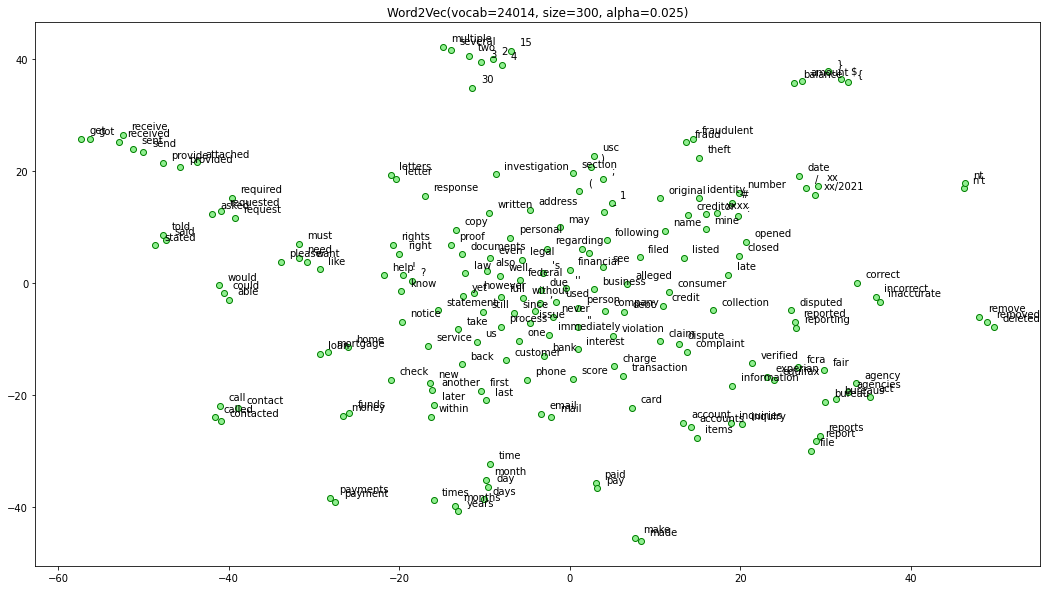

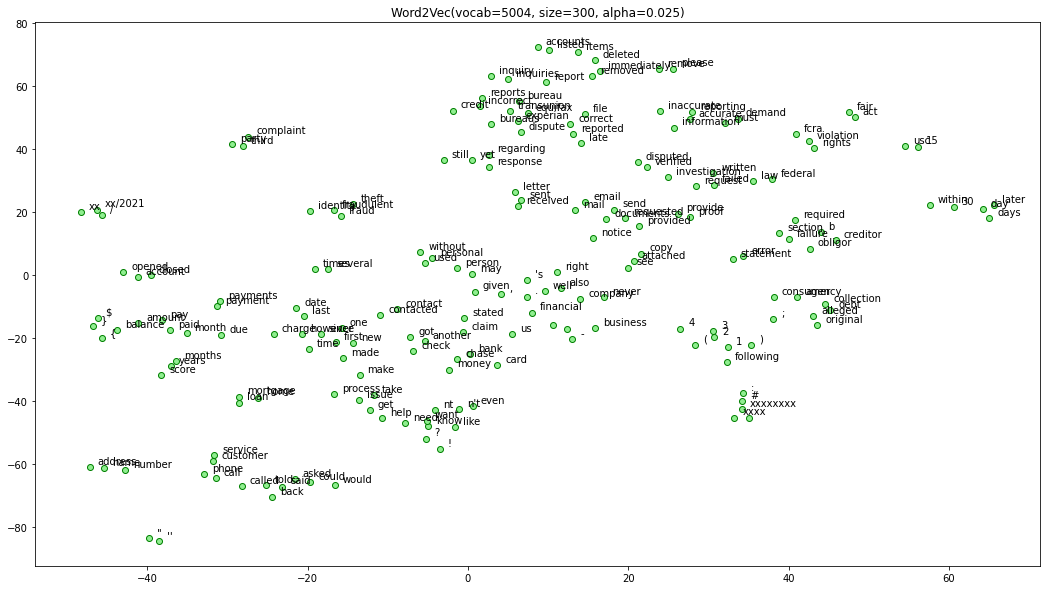

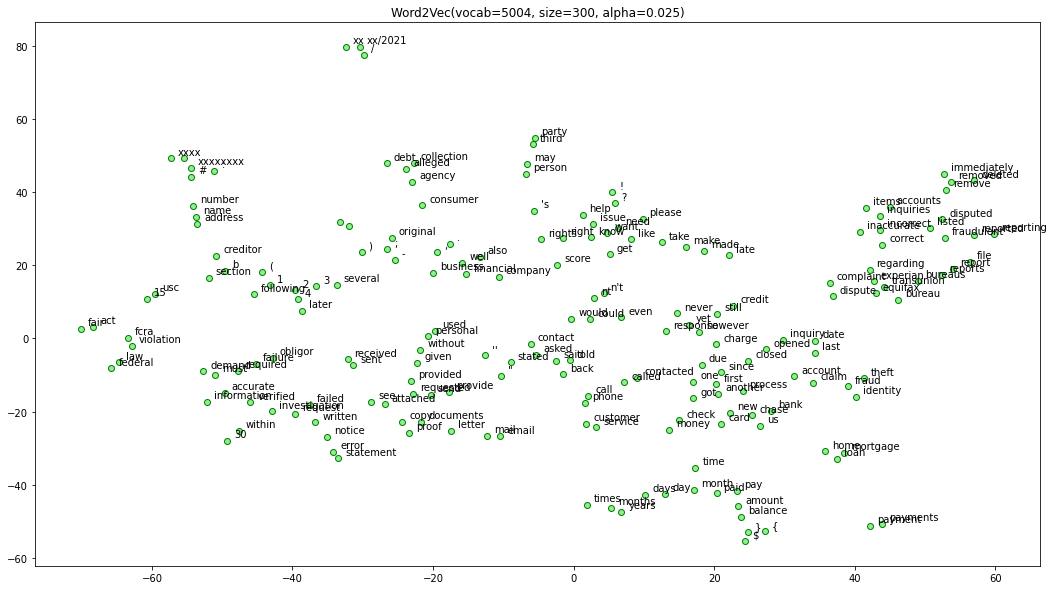

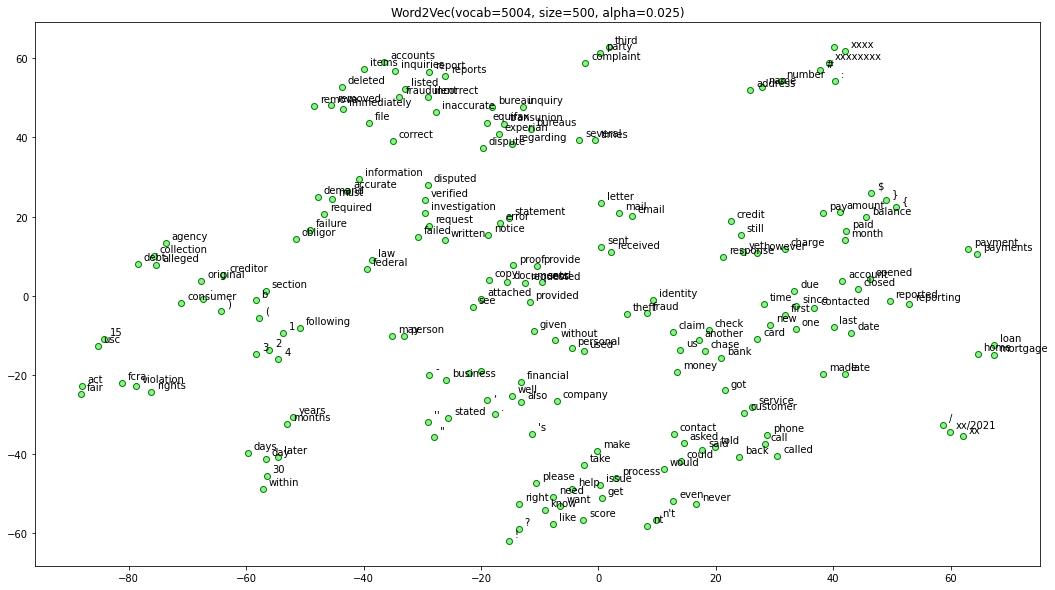

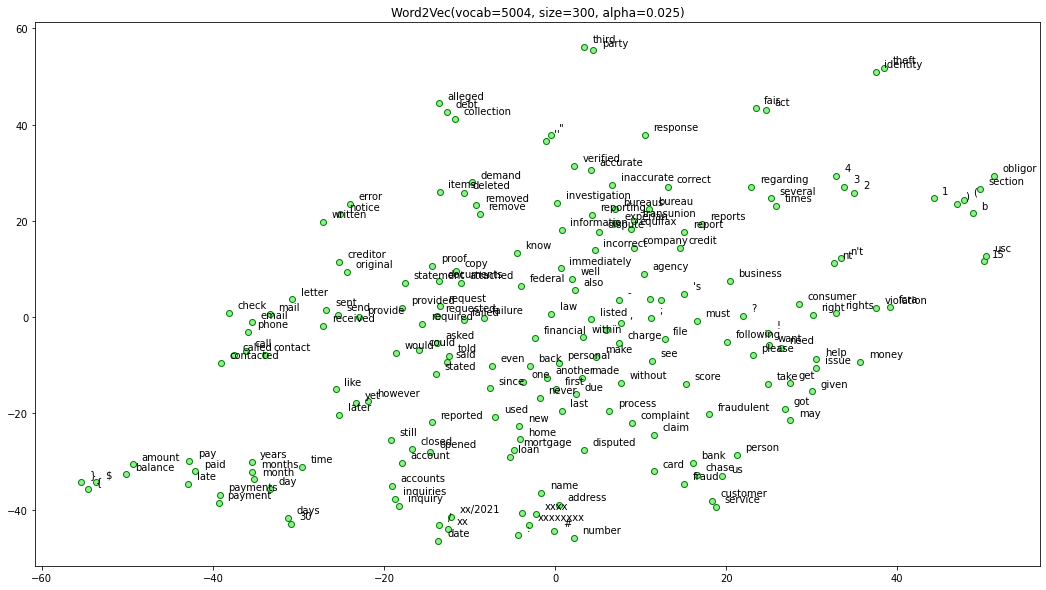

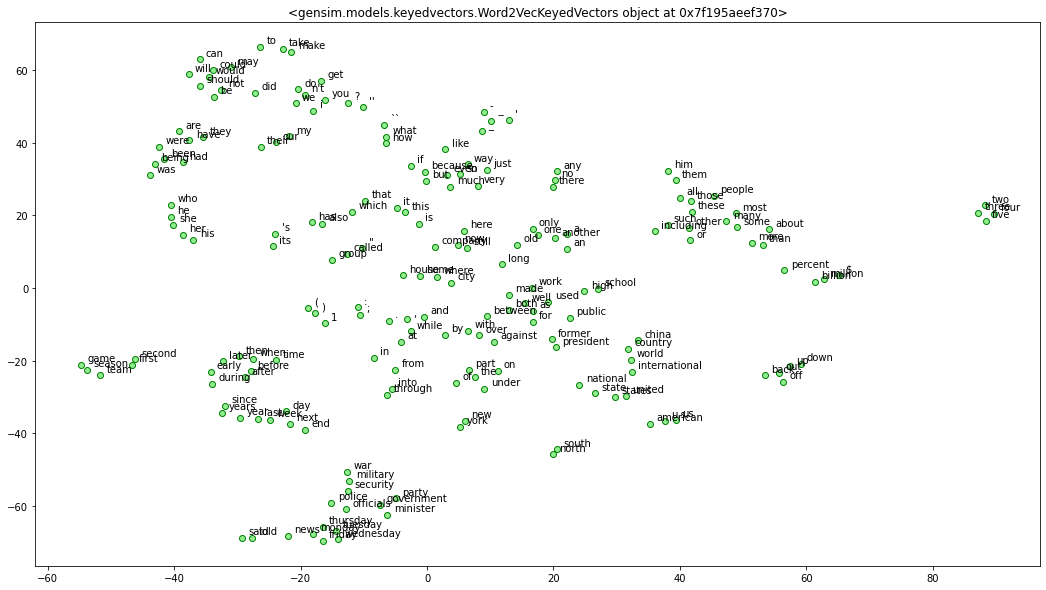

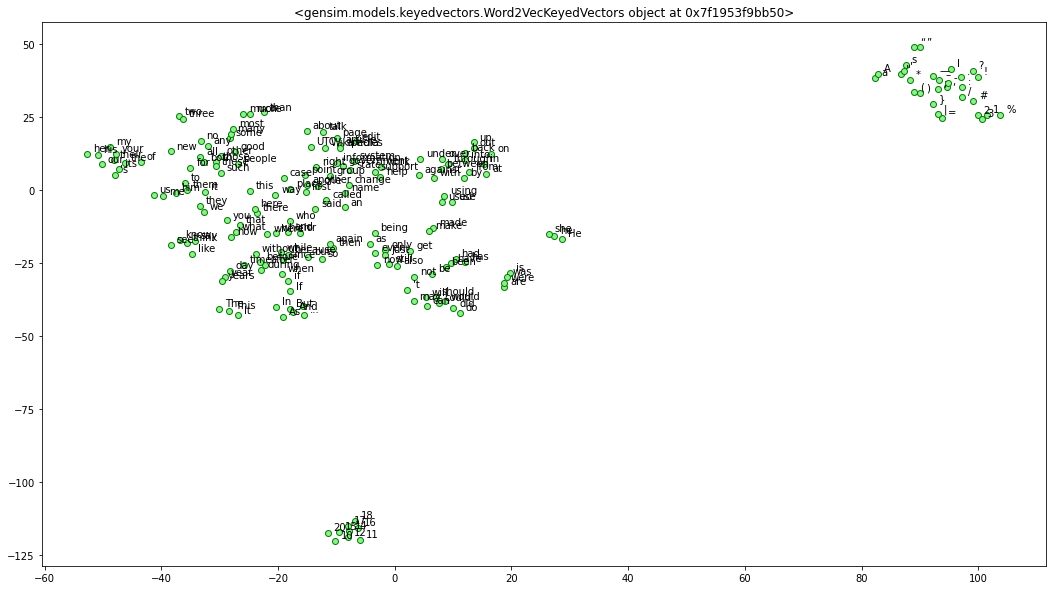

In [ ]:
from sklearn.manifold import TSNE
#iterate through all models and create different plots
for model in Models:
  words = model.wv.index2word[0:200]      ## different vocab for each model - obviously different results, but interesting
  wvs = model.wv[words]                    

  tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=5)
  np.set_printoptions(suppress=True)
  T = tsne.fit_transform(wvs)
  labels = words

  plt.figure(figsize=(18, 10))
  plt.title(model)
  plt.scatter(T[:, 0], T[:, 1], c='lightgreen', edgecolors='g')
  for label, x, y in zip(labels, T[:, 0], T[:, 1]):
      plt.annotate(label,
                  xy=(x + 1, y + 1),
                  xytext=(0, 0),
                  textcoords='offset points')

Interpretation: All models act very differently in the visualization of the semantic space, because they pick 200 words out of their indexes. They dont share necessarly the same vocabulary. The highest number of clusters and the fewest number of words alone in space are for the two pre-trained models and for the Word2Vec Model 1.

Next I want to have closer look on the very first model "w2vmodel_complete" and make an interpretation:

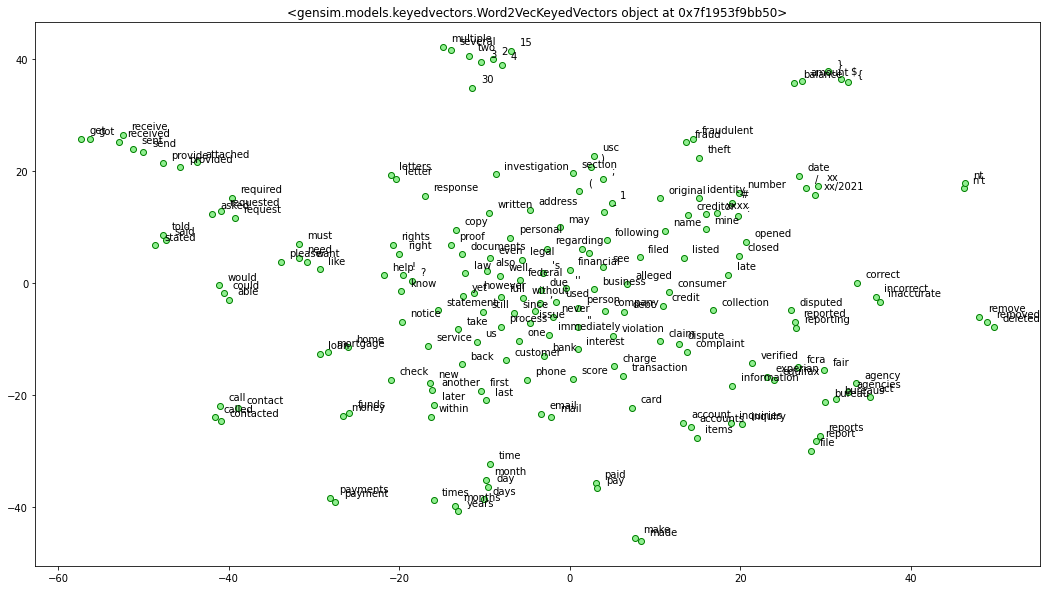

In [ ]:
words = w2vmodel_complete.wv.index2word[0:200]     
wvs = w2vmodel_complete.wv[words]                   

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
plt.title(model)
plt.scatter(T[:, 0], T[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                xy=(x + 1, y + 1),
                xytext=(0, 0),
                textcoords='offset points')

Interpretation of the w2vmodel_complete model: 
Via t-SNE, words are represented as close to each other if they have a high similarity. Therefore, there are some clusters of words.

Some examples inside the clusters:
- make and made
- paid and pay
- email and mail
- agency, angecies, bureau
- call, contact, callled, contacted

Words that do not have much similarity are far apart. This is particularly noticeable with words that stand alone in space, such as credit, connsumer or card.

Of these individual words in the "space", the closest partner can also be determined by measuring where the smallest distance is. Using "card" as an example, the closest word would be "account". It is certainly true that a card requires an account. However, I would argue that there are even better words in the Word2Vec model.

The fact that no better similarity was found is due to the fact that only 200 words were taken as a sample from the entire vocabulary. Theoretically, there should be words that have a higher similarity. This will be tested:

In [ ]:
print("card and account:", w2vmodel_complete.wv.similarity('card', 'account'))
print("card", w2vmodel_complete.wv.most_similar("card", topn=10))
print("account", w2vmodel_complete.wv.most_similar("account", topn=10))

card and account: 0.3491788
card [('cards', 0.740693211555481), ('mastercard', 0.6242377161979675), ('visa', 0.5542703866958618), ('amazon', 0.4939189553260803), ('costco', 0.48689740896224976), ('karma', 0.479125440120697), ('platinum', 0.4749917685985565), ('card-', 0.46852028369903564), ('card/', 0.4606506824493408), ('bestbuy', 0.45475947856903076)]
account [('accounts', 0.649964451789856), ('acct', 0.5623220205307007), ('accout', 0.5191864967346191), ('acount', 0.5017485618591309), ('account-', 0.4242629408836365), ('balance', 0.410933256149292), ('accts', 0.36702287197113037), ('ending', 0.3567781150341034), ('card', 0.3491787910461426), ('item', 0.3407285213470459)]


As suspected. Card and Account are classified with a low similarity value of 0.349. For card, "account" does not appear at all in the top 10. For account, card appears in 9th place.

It could be interesting to compare different models by showing the distances to one specific word. I selected the word "days" with the given code of the lecturer. The reason for selecting "days" is because  its a really determined word with clear definition behind it.

In [ ]:
# Select topn similar words to a given token

def display_closestwords_tsnescatterplot(model, word, size):
    
    arr = np.empty((0,size), dtype='f')
    word_labels = [word]
    close_words = model.wv.similar_by_word(word, topn=100)
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.figure(figsize=(15, 8))
    plt.scatter(x_coords, y_coords)
    plt.title(model)
    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

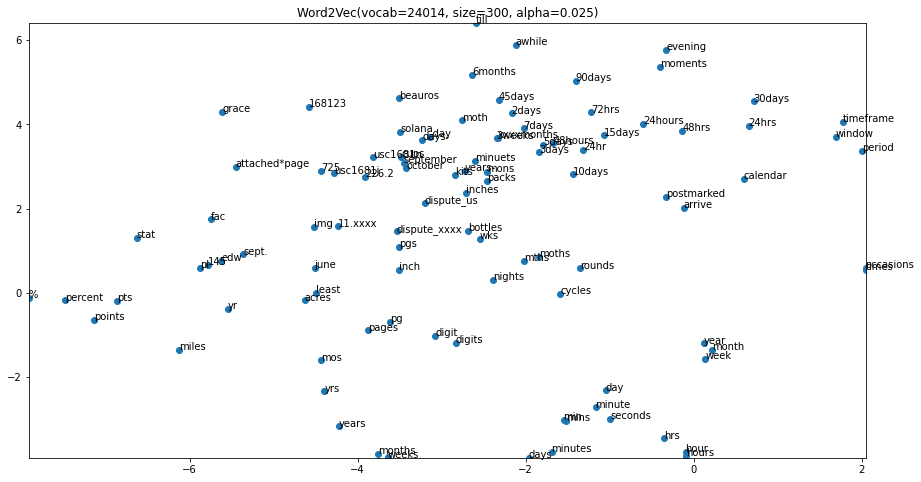

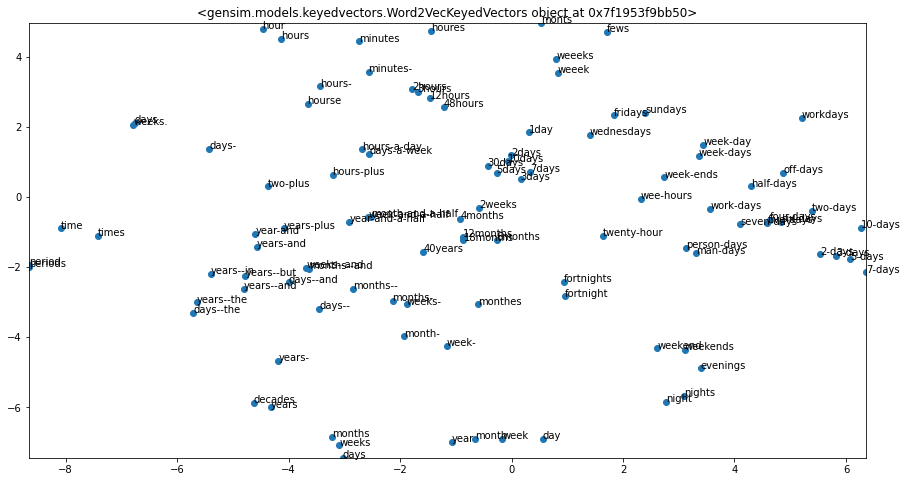

In [ ]:
# Different Models for the word days
display_closestwords_tsnescatterplot(w2vmodel_complete, 'days', 300) # Word2 Vec - Complete Model
display_closestwords_tsnescatterplot(ft_vectors, 'days', 300) # fasttext model

Interpretation: 
In general one can see that vocabulary for both selected models, which should be compared is different. 

- Word2Vec Model:
For the word 'days' the w2v model can find some very nice similar words, e.g. the cluster in the bottom right corner: day, minute, seconds, hrs, hour,...in different spelling versions (also with typos).
Another cluster is focussing more on the calendar dimension month, year, week.
There are even a cluster with specific month names "September" and October".

Other words seems a bit missplaced like percent, points, pts or miles. They are not relating to the "time" dimension. It could be now interesting why Word2Vec put this as most similar words.

- Fast Text Model:
There are even more different spelling versions (also typos) in the fasttext model. However in contrast to the Word2Vec Model all of the "most similar" words are time driven. There is no exception or any missplaced word. We lose missplaced words which were part of the Word2Vec Model. 



## Word Net

In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('wordnet_ic')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet_ic to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet_ic.zip.


True

### Synsets

In [ ]:
print(wn.synsets('credit'))
print(wn.synsets('loan'))

print(wn.synsets('sad'))
print(wn.synsets('went'))

[Synset('recognition.n.03'), Synset('credit.n.02'), Synset('credit.n.03'), Synset('credit.n.04'), Synset('credit.n.05'), Synset('credit.n.06'), Synset('citation.n.03'), Synset('credit.n.08'), Synset('credit_rating.n.01'), Synset('credit.v.01'), Synset('accredit.v.03'), Synset('credit.v.03'), Synset('credit.v.04')]
[Synset('loan.n.01'), Synset('loanword.n.01'), Synset('lend.v.02')]
[Synset('sad.a.01'), Synset('sad.s.02'), Synset('deplorable.s.01')]
[Synset('travel.v.01'), Synset('go.v.02'), Synset('go.v.03'), Synset('become.v.01'), Synset('go.v.05'), Synset('run.v.05'), Synset('run.v.03'), Synset('proceed.v.04'), Synset('go.v.09'), Synset('go.v.10'), Synset('sound.v.02'), Synset('function.v.01'), Synset('run_low.v.01'), Synset('move.v.13'), Synset('survive.v.01'), Synset('go.v.16'), Synset('die.v.01'), Synset('belong.v.03'), Synset('go.v.19'), Synset('start.v.09'), Synset('move.v.15'), Synset('go.v.22'), Synset('go.v.23'), Synset('blend.v.02'), Synset('go.v.25'), Synset('fit.v.02'), Syn

In [ ]:
# Loan
print(wn.synset('loan.n.01').definition())
print(wn.synset('loanword.n.01').definition())
print(wn.synset('lend.v.02').definition())

the temporary provision of money (usually at interest)
a word borrowed from another language; e.g. `blitz' is a German word borrowed into modern English
give temporarily; let have for a limited time


According to Word Net the word "Loan" has at least 3 different meanings.

In [ ]:
# Credit
print(wn.synset('credit.n.02').definition())
print(wn.synset('recognition.n.03').definition())
print(wn.synset('citation.n.03').definition())
print(wn.synset('accredit.v.03').definition())
print(wn.synset('credit_rating.n.01').definition())

money available for a client to borrow
approval
a short note recognizing a source of information or of a quoted passage
ascribe an achievement to
an estimate, based on previous dealings, of a person's or an organization's ability to fulfill their financial commitments


According to Word Net the word "Credit" has at least 3 different meanings.

In [ ]:
# Definitions
credit = wn.synset('credit.n.02')
loan = wn.synset('loan.n.01') 
sad = wn.synset('sad.a.01') 
went = wn.synset('go.v.03')

### Lemmas, Synonyms, Antonyms

Lemmas

In [ ]:
for lemma in wn.synset('go.v.03').lemmas():
  print(lemma, lemma.frame_ids())
  print(" | ".join(lemma.frame_strings()))

Lemma('go.v.03.go') [1, 2, 4, 22]
Something go | Somebody go | Something is going PP | Somebody go PP
Lemma('go.v.03.go_away') [1, 2, 4, 22]
Something go_away | Somebody go_away | Something is go_awaying PP | Somebody go_away PP
Lemma('go.v.03.depart') [1, 2, 4, 22]
Something depart | Somebody depart | Something is departing PP | Somebody depart PP


Synonyms:

In [ ]:
# Credit
synonyms = []

for syn in wn.synsets("credit"):
    for i in syn.lemmas():
        synonyms.append(i.name())

print(set(synonyms))

{'course_credit', 'deferred_payment', 'accredit', 'reference', 'citation', 'credit_entry', 'cite', 'credit_rating', 'acknowledgment', 'credit', 'mention', 'recognition', 'quotation'}


In [ ]:
# Loan
synonyms = []

for syn in wn.synsets("loan"):
    for i in syn.lemmas():
        synonyms.append(i.name())

print(set(synonyms))

{'lend', 'loanword', 'loan'}


In [ ]:
# Sad
synonyms = []

for syn in wn.synsets("sad"):
    for i in syn.lemmas():
        synonyms.append(i.name())

print(set(synonyms))

{'pitiful', 'deplorable', 'sorry', 'distressing', 'lamentable', 'sad'}


Antonyms: 

In [ ]:
# Credit
antonyms = []

for syn in wn.synsets("credit"):
    for i in syn.lemmas():
         if i.antonyms():
              antonyms.append(i.antonyms()[0].name())

print(set(antonyms))

{'debit', 'cash'}


In [ ]:
# Loan
antonyms = []

for syn in wn.synsets("loan"):
    for i in syn.lemmas():
         if i.antonyms():
              antonyms.append(i.antonyms()[0].name())

print(set(antonyms))

{'borrow'}


In [ ]:
# Sad
antonyms = []

for syn in wn.synsets("sad"):
    for i in syn.lemmas():
         if i.antonyms():
              antonyms.append(i.antonyms()[0].name())

print(set(antonyms))

{'glad'}


### Similarity

In [ ]:
print(credit.wup_similarity(loan))

0.6153846153846154


WordNet suggests a similarity of 0.615. In the glove vector model the similarity score was 0.54181945. The highest similarity score was achieved with the Word2Vec Model 4 with a value of 0.23306534

## Summary: Learning, Pros and Cons


### Summary and Learnings

In this exercise, different methods of text vectorisation were practised and presented on pre processed data (tokenized and without stop words).

After training various word2vec, the **first step** was to test the embeddings and see which were the *top n similar words* for a list of most frequent and a list of domain specific. In general, there was no trained word2vec model whose similar word results I would consider particularly catastrophically bad. Only on the basis of top n would it be difficult to decide on a model.

The **second step** was to analyse the **similarity** of two specific word pairs:
"credit to loan" and "comma to dot".  Intuitively, we use the word "credit" as a synonym for the word "loan". Therefore, my expectation was that the similarity should be particularly high. The same applies to the similarity between comma "," and dot ".". One could see that some models could determine a higher Similarity. The best Word2Vec model for this application was the so-called "Model 4". It had the following parameters:

feature_size = 300  
window_context = 5  
min_word_count = 5  
sg = 1 # Changed to Skip Gram

**Thirdly** the visualisation of the semantic space was now added.
Via t-SNE, words are represented as close to each other if they have a high similarity. Words which are very close to each other form a cluster. It was first tested with the first 200 words of the vocabulary in each model which has led to various visualisations. A similarity visualisation was then carried out using the word "days".

**Lastly** I checked the usage of Word Net.
Intuitively i assumed that credit and loan are synonyms and should have a high similarity. But I completely forgot and neglected, and this was shown, that there are different word meanings for both words. Therefore, I see a great field of application for Word Net precisely in testing for such multiple interpretations. 
It is therefore logical that the word2vec models in particular have problems in calculating similarity. In order to distinguish and differentiate between the various word meanings, much more text is needed. The pretrained models, on the other hand, are based on huge amounts of text and can therefore calculate a higher similarity between credit and loan.

Different Definitions of Credit:
1. money available for a client to borrow
2. approval
3. a short note recognising a source of information or of a quoted passage
4. ascribe an achievement to
5. an estimate, based on previous dealings, of a person's or an organisation's ability to fulfil their financial obligations.

Different Definitions of Loan:
1. the temporary provision of money (usually at interest)
2. a word borrowed from another language; e.g. `blitz' is a German word borrowed into modern English
3. give temporarily; let have for a limited time




### Pros and Cons



In general I would summarize the strenght of weakness of both models as follows: 

Fast Text (or Glove) can be very precisely and show the actual lexicon similarities to any specific word. The Word2Vec Model on the other side is trained on a specific text. It contains more missplaced words. But these missplaced words could contain useful information and could give more context to some words (as seen with the word "days"). Word 2 Vec has shown some outlier behavior, which we could completely lose with the pretrained models. Pre trained Models are very high level optimized models and not specifily designed for one domain.

The use of wordnet can be very useful to check definitions and lemmas of single words via synsets. This was done with the word "credit" and "loan" and provided me an insightful information. It is also possible to calculate the similarity with Word Net.  